# Christian Rosado - Extra Credit 

# I prepared a dataset of hospital facilities Asthma dismissal records and uploaded it to Carto. 
## download it with an SQL query. Use the function I provide below.
## The name of the DB is NYCAsthmasDismissals
## *within the SQLquery* group the data by zipcode.

In [2]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import os
from geopandas import GeoDataFrame
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist, squareform
import seaborn
import zipfile as zf
%matplotlib inline

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''SELECT count(zipcodes), zipcodes 
                   FROM nycasthmasdismissals
                   GROUP BY zipcodes;
                '''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.
# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [3]:
# Dowloading data
#os.system("curl -O https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip")
#os.system("mv nycb2010_16d.zip PUIDATA")
#os.system("sudo apt-get install unzip")
#os.getenv("PUIDATA")
#os.system('unzip YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip -d + os.getenv("PUIDATA")')
#import zipfile as zf
!curl -O "https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip"
zip_ref = zf.ZipFile('YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip',
'r')
zip_ref.extractall(os.getenv("PUIDATA"))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1478k  100 1478k    0     0   704k      0  0:00:02  0:00:02 --:--:--  879k


In [4]:
#from geopandas import GeoDataFrame
shape_path= os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp"
zip_shape = GeoDataFrame.from_file(shape_path)
#zip_shape.index=ct_shape.BoroCT2010

In [5]:
zip_shape.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


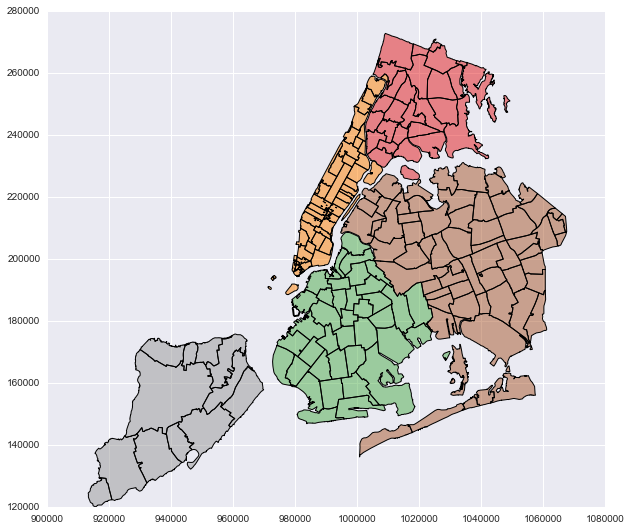

In [6]:
zip_shape.plot(figsize=(10,10), column='COUNTY')

In [7]:
zip_shape.ZIPCODE = pd.to_numeric(zip_shape.ZIPCODE)

In [8]:
zip_shape = zip_shape.merge(facilities, right_on='zipcodes', left_on='ZIPCODE')
zip_shape = zip_shape.iloc[:,-3:]

In [9]:
zip_shape['centers'] = zip_shape.centroid

In [10]:
zip_shape = zip_shape.iloc[:,-3:]

In [11]:
zip_shape.head()

,count,zipcodes,centers
0,376,11213,POINT (1001912.871996466 183803.1131420481)
1,713,11212,POINT (1008365.375095716 180768.9448568909)
2,421,11219,POINT (985172.779324743 169813.4852984693)
3,494,10466,POINT (1026647.114925691 263909.2896452093)
4,2164,10467,POINT (1020059.119296007 259287.5178783316)


# Create a 3xN numpy array with x-location, y-location, number of dismissals

In [12]:
import numpy as np

In [13]:
krigdata = np.zeros((len(zip_shape),3))

In [14]:
for i in range(len(zip_shape)):
    krigdata[i,0] = zip_shape['centers'][i].coords[0][0]
    krigdata[i,1] = zip_shape['centers'][i].coords[0][1]
    krigdata[i,2] = zip_shape['count'][i]

In [15]:
krigdata

array([[  1.00191287e+06,   1.83803113e+05,   3.76000000e+02],
       [  1.00836538e+06,   1.80768945e+05,   7.13000000e+02],
       [  9.85172779e+05,   1.69813485e+05,   4.21000000e+02],
       [  1.02664711e+06,   2.63909290e+05,   4.94000000e+02],
       [  1.02005912e+06,   2.59287518e+05,   2.16400000e+03],
       [  1.02829272e+06,   2.47902428e+05,   1.69900000e+03],
       [  1.01237400e+06,   2.47427241e+05,   8.22000000e+02],
       [  1.00976434e+06,   2.41746681e+05,   1.07200000e+03],
       [  1.00535896e+06,   2.38316068e+05,   1.69800000e+03],
       [  1.00461252e+06,   2.20393721e+05,   2.81000000e+02],
       [  1.03375196e+06,   2.13025445e+05,   6.41000000e+02],
       [  1.00620449e+06,   1.95763534e+05,   1.15600000e+03],
       [  1.00021475e+06,   1.95030042e+05,   4.66000000e+02],
       [  9.87194513e+05,   1.92431928e+05,   9.40000000e+02],
       [  9.89857162e+05,   1.81769963e+05,   5.21000000e+02],
       [  1.00248639e+06,   1.75967925e+05,   1.8290000

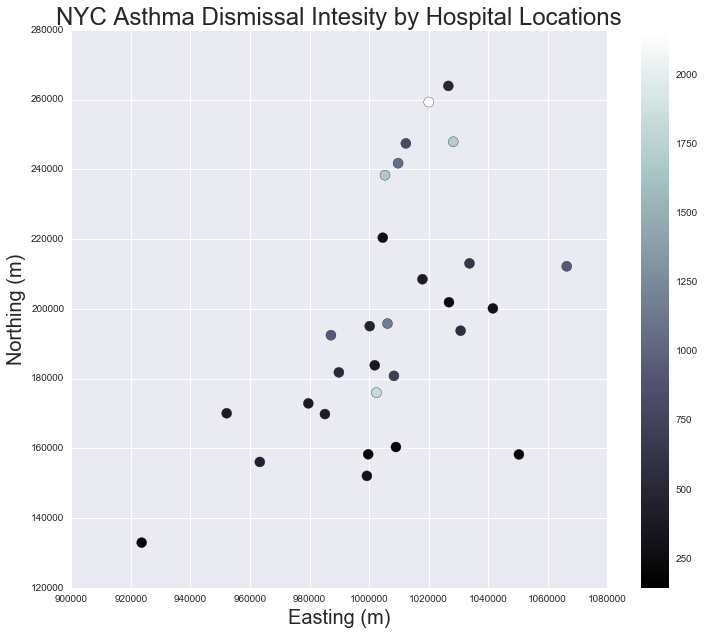

In [31]:
plt.figure(figsize=(12,10))
plt.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
#zip_shape.plot(figsize=(10,10))
plt.xlabel("Easting (m)", fontsize=20)
plt.ylabel("Northing (m)", fontsize=20)
plt.title('NYC Asthma Dismissal Intesity by Hospital Locations', fontsize=24)
plt.colorbar()

Figure 1: The plot above shows Asthma Dismissal counts by location of NYC Hospitals on a northing vs. easting cordinate space.

# Create and try to model the semi-variogram as we did in class
# https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
# Explain what is going on

In [25]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [26]:
lag = 400
mysv = SV( krigdata, np.arange(1, 40000, lag), 1000 )

/Users/christianrosado/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in double_scalars


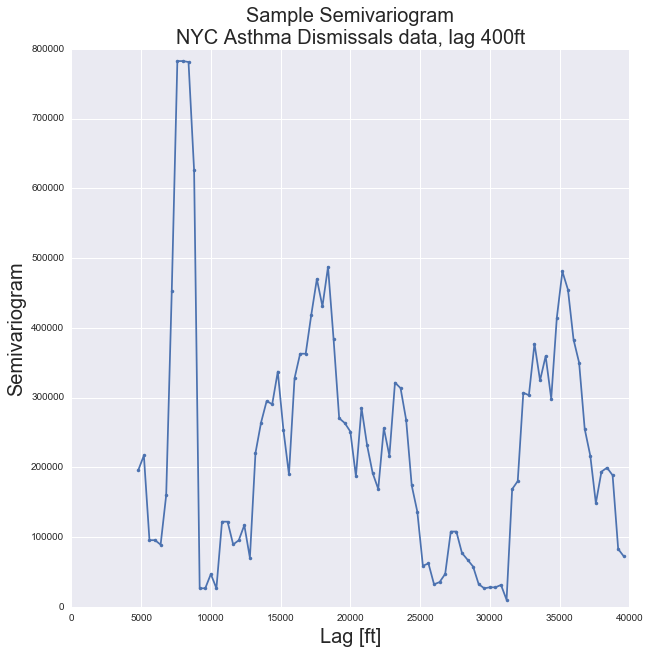

In [27]:
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0, 10500, lag)
#mysv = SV( x, hs, bw )
plt.figure(figsize=(10,10))
plt.plot( mysv[0], mysv[1], '.-' )
plt.xlabel('Lag [ft]', fontsize=20)
plt.ylabel('Semivariogram', fontsize=20)
plt.title('Sample Semivariogram\nNYC Asthma Dismissals data, lag %dft'%lag, fontsize=20) 

Figure 2: Semivariogram - the lag on the x-axis measures the distance between points, and the y-axis shows how similar points are to each other based on the plotted distance. The curve we saw in class for the porosity lab shows that there is a relationship between space and points due to its semismooth platoed curve. However, for the above semivariogram, we see a crazy-acting pattern conveying no relationship between hospitals (given space) and asthma dismissals (given points - data). The y-scale does not have to be normalized to 0-1.
